# Saswata Rautray
# Kodjo Botchway

In [73]:
import os
import numpy as np 
import pandas as pd 

import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers

from kaggle_datasets import KaggleDatasets
from sklearn.model_selection import train_test_split

# random seed
np.random.seed(42)

### Detect and setup TPU

In [74]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
    
print('Number of replicas in sync:', strategy.num_replicas_in_sync)

2022-04-14 23:03:00.019054: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:301] Initialize GrpcChannelCache for job worker -> {0 -> 10.0.0.2:8470}
2022-04-14 23:03:00.019505: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:301] Initialize GrpcChannelCache for job localhost -> {0 -> localhost:30042}
2022-04-14 23:03:00.022385: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:301] Initialize GrpcChannelCache for job worker -> {0 -> 10.0.0.2:8470}
2022-04-14 23:03:00.022618: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:301] Initialize GrpcChannelCache for job localhost -> {0 -> localhost:30042}


Number of replicas in sync: 8


### Set up some global variables

In [75]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 16 * strategy.num_replicas_in_sync
IMAGE_SIZE = [224, 224]
EPOCHS = 25

### Read the training, validation and test data

In [76]:
# get GCS path of the dataset
GCS_PATH = KaggleDatasets().get_gcs_path()
GCS_PATH

'gs://kds-ff538c0d42f728698d29a9cf44dd80c68937ac4df7304fad43a5705b'

In [77]:
# get filenames from train and validation data
image_files = tf.io.gfile.glob(str(GCS_PATH + '/chest_xray/train/*/*'))
image_files.extend(tf.io.gfile.glob(str(GCS_PATH + '/chest_xray/val/*/*')))

# split data into train and validation set
train_files, val_files = train_test_split(image_files, 
                                          test_size = 0.2, 
                                          random_state = 42)

2022-04-14 23:03:06.388312: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.
2022-04-14 23:03:06.492585: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.
2022-04-14 23:03:06.602873: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.
2022-04-14 23:03:06.702401: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.
2022-04-14 23:03:06.806864: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.


### Create training and validation datasets

In [78]:
train_ds = tf.data.Dataset.from_tensor_slices(train_files)
val_ds = tf.data.Dataset.from_tensor_slices(val_files)

# check the number of training and validation images
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_ds).numpy()
VAL_IMG_COUNT = tf.data.experimental.cardinality(val_ds).numpy()

print(f'Number of training images: {TRAIN_IMG_COUNT}')
print(f'Number of validation images: {VAL_IMG_COUNT}')

Number of training images: 4185
Number of validation images: 1047


### Number of images in each class in training data

In [79]:
# count the number of normal and pneumonia images in the training data set
COUNT_NORMAL = len([file for file in train_files if 'NORMAL' in file])
print(f'Normal images count in training data: {COUNT_NORMAL}')

COUNT_PNEUMONIA = len([file for file in train_files if 'PNEUMONIA' in file])
print(f'Pneumonia images count in training data: {COUNT_PNEUMONIA}')

Normal images count in training data: 1059
Pneumonia images count in training data: 3126


- The dataset is imbalanced as the number of normal images are much less than the pneumonia images

In [80]:
# complete path of the training images
for path in train_ds.take(5):
    print(path.numpy())

b'gs://kds-ff538c0d42f728698d29a9cf44dd80c68937ac4df7304fad43a5705b/chest_xray/train/NORMAL/NORMAL2-IM-1062-0001.jpeg'
b'gs://kds-ff538c0d42f728698d29a9cf44dd80c68937ac4df7304fad43a5705b/chest_xray/train/PNEUMONIA/person1525_virus_2659.jpeg'
b'gs://kds-ff538c0d42f728698d29a9cf44dd80c68937ac4df7304fad43a5705b/chest_xray/train/PNEUMONIA/person1129_bacteria_3070.jpeg'
b'gs://kds-ff538c0d42f728698d29a9cf44dd80c68937ac4df7304fad43a5705b/chest_xray/train/PNEUMONIA/person1667_bacteria_4417.jpeg'
b'gs://kds-ff538c0d42f728698d29a9cf44dd80c68937ac4df7304fad43a5705b/chest_xray/train/NORMAL/NORMAL2-IM-0725-0001.jpeg'


2022-04-14 23:03:07.246569: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 54610, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1649977387.246515688","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 54610, Output num: 0","grpc_status":3}


In [81]:
# class names
CLASS_NAMES = np.array([str(tf.strings.split(item, os.path.sep)[-1].numpy())[2:-1]
                        for item in tf.io.gfile.glob(str(GCS_PATH + "/chest_xray/train/*"))])
CLASS_NAMES

2022-04-14 23:03:07.254519: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.
2022-04-14 23:03:07.358133: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.
2022-04-14 23:03:07.461909: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.
2022-04-14 23:03:07.556257: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.
2022-04-14 23:03:07.659505: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.


array(['NORMAL', 'PNEUMONIA'], dtype='<U9')

### Prepare data

In [82]:
def get_label(file_path):
    # convert the path to a list of path components
    parts = tf.strings.split(file_path, os.path.sep)
    # The second to last is the class-directory
    return parts[-2] == "PNEUMONIA"

In [83]:
def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img, channels = 3)
  # Use `convert_image_dtype` to convert to floats in the [0, 1] range
  img = tf.image.convert_image_dtype(img, tf.float32)
  # resize the image to the desired size.
  return tf.image.resize(img, IMAGE_SIZE)

In [84]:
def process_path(file_path):
    label = get_label(file_path)
    # load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

In [85]:
train_ds = train_ds.map(process_path, num_parallel_calls = AUTOTUNE)
val_ds = val_ds.map(process_path, num_parallel_calls = AUTOTUNE)

# check the shape of images
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (224, 224, 3)
Label:  False


### Prepare test images


In [86]:
test_ds = tf.data.Dataset.list_files(str(GCS_PATH + '/chest_xray/test/*/*'))
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_ds).numpy()
test_ds = test_ds.map(process_path, num_parallel_calls = AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

TEST_IMAGE_COUNT

624

In [87]:
# This is a small dataset, only load it once, and keep it in memory
# use `.cache(filename)` to cache preprocessing work for datasets that don't
# fit in memory
train_ds = train_ds.cache().shuffle(buffer_size = 1000)

# Repeat forever
# `prefetch` lets the dataset fetch batches in the background while the model
# is training
train_ds = train_ds.repeat().batch(BATCH_SIZE).prefetch(buffer_size = AUTOTUNE)

val_ds = val_ds.cache().shuffle(buffer_size = 1000).repeat().batch(BATCH_SIZE)
val_ds = val_ds.prefetch(buffer_size = AUTOTUNE)

# 1) How many samples are present? Print number of images for NORMAL & PNEUMONIA in training, validation and test images (1 pt)

In [88]:
print("Samples present is ", TRAIN_IMG_COUNT + VAL_IMG_COUNT + TEST_IMAGE_COUNT)

Samples present is  5856


In [89]:
# count the number of normal and pneumonia images in the training data set
COUNT_NORMAL = len([file for file in train_files if 'NORMAL' in file])
print(f'Normal images count in training data: {COUNT_NORMAL}')

COUNT_PNEUMONIA = len([file for file in train_files if 'PNEUMONIA' in file])
print(f'Pneumonia images count in training data: {COUNT_PNEUMONIA}')

Normal images count in training data: 1059
Pneumonia images count in training data: 3126


In [90]:
# count the number of normal and pneumonia images in the validation data set
COUNT_NORMAL = len([file for file in val_files if 'NORMAL' in file])
print(f'Normal images count in validation data: {COUNT_NORMAL}')

COUNT_PNEUMONIA = len([file for file in val_files if 'PNEUMONIA' in file])
print(f'Pneumonia images count in validation data: {COUNT_PNEUMONIA}')

Normal images count in validation data: 290
Pneumonia images count in validation data: 757


In [91]:
# the number of normal and pneumonia images in the test data set will be known after the model

---
---

### Display batch of images

In [92]:
def show_batch(image_batch, label_batch):
    plt.figure(figsize = (10,10))
    for n in range(16):
        ax = plt.subplot(4, 4, n + 1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")

In [93]:
# call the next batch 
image_batch, label_batch = next(iter(train_ds))

In [94]:
image_batch.shape

TensorShape([128, 224, 224, 3])

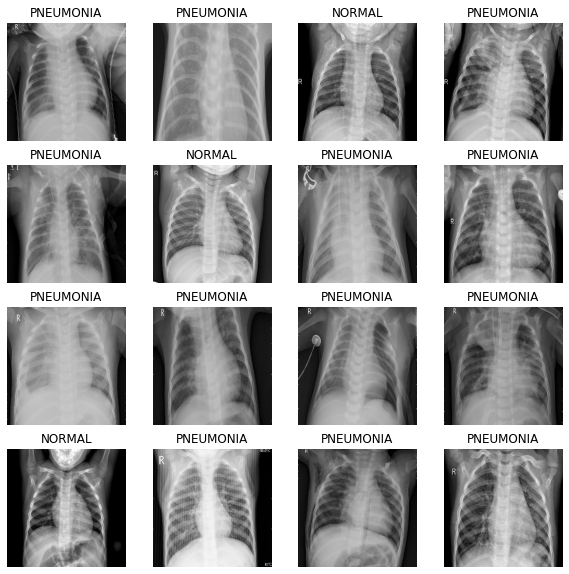

In [95]:
# show batch of images
show_batch(image_batch.numpy(), label_batch.numpy())

# Can you tell the difference between normal and pathological examples? Visualize them by considering 4-5 samples each (1 pt)

### From the images, it can be seen that Pneumonia samples appear distinct from the normal images. The distinctness is visibly because of the contrast of the images. The Pneumonia samples appear light while the nmormal ones appear dark.

___
___

# Load Imagenet pretrained InceptionV3 model (1 pt) 

### Transfer Learning using InceptionV3

In [105]:
with strategy.scope():
    base_model = tf.keras.applications.InceptionV3(include_top = False, 
                                           weights = 'imagenet', 
                                           input_shape = (224, 224, 3))
    base_model.trainable = False
    
    pool_out = layers.GlobalAveragePooling2D()(base_model.output)
    pool_out = layers.Dropout(0.3)(pool_out)
    output = layers.Dense(1, activation = 'sigmoid')(pool_out)
    
    inception = tf.keras.Model(base_model.input, output)
    
    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name = 'precision'),
        tf.keras.metrics.Recall(name = 'recall')
    ]
    
    inception.compile(
        optimizer = 'adam',
        loss = 'binary_crossentropy',
        metrics = METRICS
    )

# Add Pooling and densely connected layers to InceptionV3 and print the model summary (2 pt)

In [106]:
inception.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_96 (Conv2D)              (None, 111, 111, 32) 864         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_101 (BatchN (None, 111, 111, 32) 96          conv2d_96[0][0]                  
__________________________________________________________________________________________________
activation_94 (Activation)      (None, 111, 111, 32) 0           batch_normalization_101[0][0]    
____________________________________________________________________________________________

# Train the model and display the loss/accuracy plot (3 pt)

In [100]:
weight_for_0 = (1 / COUNT_NORMAL) * (TRAIN_IMG_COUNT) / 2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA) * (TRAIN_IMG_COUNT) / 2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 7.22
Weight for class 1: 2.76


In [107]:
# finetune the model
history = inception.fit(
    train_ds,
    steps_per_epoch = TRAIN_IMG_COUNT // BATCH_SIZE,
    epochs = EPOCHS,
    validation_data = val_ds,
    validation_steps = VAL_IMG_COUNT // BATCH_SIZE,
    class_weight = class_weight
)

Epoch 1/25
32/32 [==============================] - 152s 3s/step - loss: 2.1966 - accuracy: 0.7257 - precision: 0.8619 - recall: 0.7592 - val_loss: 0.3386 - val_accuracy: 0.8555 - val_precision: 0.9744 - val_recall: 0.8216
Epoch 2/25
32/32 [==============================] - 2s 77ms/step - loss: 1.2224 - accuracy: 0.8608 - precision: 0.9522 - recall: 0.8579 - val_loss: 0.2508 - val_accuracy: 0.9062 - val_precision: 0.9749 - val_recall: 0.8932
Epoch 3/25
32/32 [==============================] - 2s 76ms/step - loss: 1.0180 - accuracy: 0.8935 - precision: 0.9609 - recall: 0.8925 - val_loss: 0.1931 - val_accuracy: 0.9346 - val_precision: 0.9720 - val_recall: 0.9366
Epoch 4/25
32/32 [==============================] - 2s 79ms/step - loss: 0.8959 - accuracy: 0.9181 - precision: 0.9641 - recall: 0.9247 - val_loss: 0.1650 - val_accuracy: 0.9541 - val_precision: 0.9741 - val_recall: 0.9623
Epoch 5/25
32/32 [==============================] - 2s 78ms/step - loss: 0.8478 - accuracy: 0.9171 - precisi

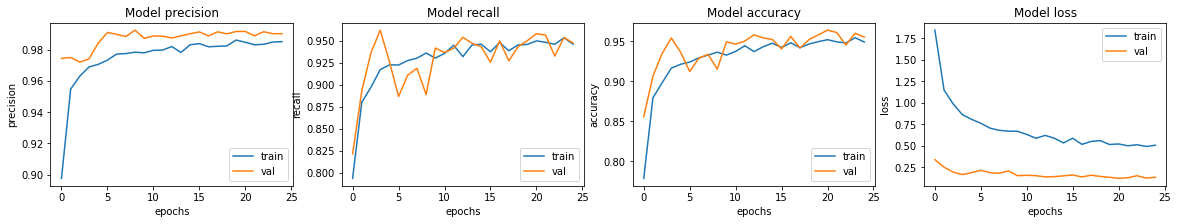

In [109]:
fig, ax = plt.subplots(1, 4, figsize = (20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

# Check the accuracy on the test images (2 pt)

In [111]:
# check the performance of inception model on test data
loss, acc, prec, rec = inception.evaluate(test_ds)

5/5 [==============================] - 23s 5s/step - loss: 0.4424 - accuracy: 0.8253 - precision: 0.7983 - recall: 0.9641


In [122]:
print("Accuracy of test data", round(acc*100, 2), "%")

Accuracy of test data 82.53 %


Our recall is greater than our precision, indicating that almost all pneumonia images are correctly identified but some normal images are falsely identified. We should aim to increase our precision.